In [1]:
%pip install fairgbm
%pip install lightgbm
%pip install folktables
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
from functools import partial
from itertools import product

import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from fairgbm import FairGBMClassifier
from folktables import ACSDataSource, BasicProblem, adult_filter
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from merlin.mean import mom, block_mean

rng = np.random.default_rng(1234)

ModuleNotFoundError: No module named 'merlin'

# Simple test with constant corruption on random labels and negative discrimination

In [ ]:
N_REPETITIONS = 50
N_SAMPLES = 1000
y = rng.choice(2, size=N_SAMPLES, p=(0.3, 0.7))
corrupted_fraction = np.concatenate(([0], np.logspace(-3, -np.log10(5), num=30)))

lower_bound = np.sqrt(corrupted_fraction) * (0.3 * 0.7)

TypeError: some keyword arguments unexpected

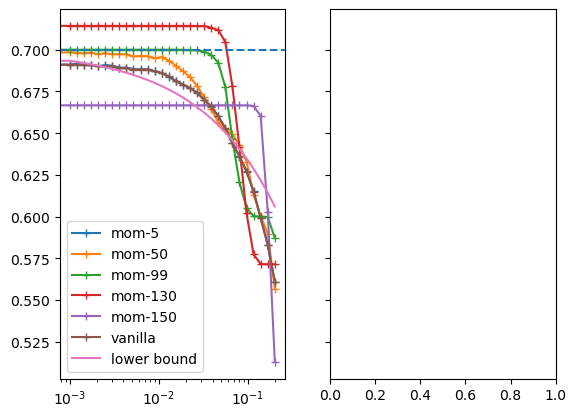

In [ ]:
fig, axes = plt.subplots(1, 2, sharey="row")

for n_groups in [5, 50, 99, 130, 150]:
    robust_estimated_mean = np.zeros_like(corrupted_fraction)
    estimated_mean = np.zeros_like(corrupted_fraction)

    for _ in range(N_REPETITIONS):
        for i, fraction in enumerate(corrupted_fraction):
            y_adv = y.copy()
            y_adv[: int(fraction * len(y))] = 0
            rng.shuffle(y_adv)

            robust_estimated_mean[i] += mom(y_adv, n_groups=n_groups, n_permutations=30)
            estimated_mean[i] += np.mean(y_adv)

    axes[0].semilogx(
        corrupted_fraction,
        (robust_estimated_mean / N_REPETITIONS),
        "+-",
        label=f"mom-{n_groups}",
    )

axes[0].semilogx(
    corrupted_fraction, (estimated_mean / N_REPETITIONS), "+-", label="vanilla"
)
axes[0].semilogx(corrupted_fraction, 0.7 - lower_bound, label="lower bound")
axes[0].axhline(0.7, ls="--")
axes[0].legend()

for n_groups in [5, 50, 99, 200, 300, 500]:
    robust_estimated_mean = np.zeros_like(corrupted_fraction)
    estimated_mean = np.zeros_like(corrupted_fraction)

    for _ in range(N_REPETITIONS):
        for i, fraction in enumerate(corrupted_fraction):
            y_adv = y.copy()
            y_adv[: int(fraction * len(y))] = 0
            rng.shuffle(y_adv)

            robust_estimated_mean[i] += block_mean(y_adv, n_blocks=n_groups)
            estimated_mean[i] += np.mean(y_adv)

    axes[1].semilogx(
        corrupted_fraction,
        (robust_estimated_mean / N_REPETITIONS),
        "+-",
        label=f"group-{n_groups}",
    )

axes[1].semilogx(corrupted_fraction, 0.7 - lower_bound, label="lower bound")
axes[1].semilogx(
    corrupted_fraction, (estimated_mean / N_REPETITIONS), "+-", label="vanilla"
)
axes[1].axhline(0.7, ls="--")
axes[1].legend()

# Test with a sandboxing attack

In [ ]:
data_source = ACSDataSource(survey_year="2018", horizon="5-Year", survey="person")
acs_data = data_source.get_data(states=["AL"], download=True)
features, label, group = BasicProblem(
    features=[
        "AGEP",
        "COW",
        "SCHL",
        "MAR",
        "OCCP",
        "POBP",
        "RELP",
        "WKHP",
        "SEX",
        "RAC1P",
    ],
    target="PINCP",
    target_transform=lambda x: x > 50000,
    group="SEX",
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
).df_to_numpy(acs_data)

print([np.sum(group == i) for i in np.unique(group)])
print(np.unique(group))

[57293, 52900]
[1 2]


In [ ]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=1234
)
print(len(X_train), len(X_test))

88154 22039


In [ ]:
N_REPETITIONS = 30
N_GROUPS_VALUES = [50, 100]
N_MOM_PERMUTATIONS = [50]
N_BLOCKS_VALUES = [50, 100]
AUDIT_BUDGET_VALUES = np.linspace(2_000, len(y_test), num=10, endpoint=True, dtype=int)
CORRUPTED_FRACTION_VALUES = np.linspace(0, 0.5, endpoint=True, num=30)

ESTIMATORS = {
    "mean": lambda y: np.mean(y),
    # "median": lambda y: np.median(y),
}
ESTIMATORS.update(
    {
        f"mom-{n_groups}-{n_permutations}": partial(
            mom, n_groups=n_groups, n_permutations=n_permutations
        )
        for n_groups, n_permutations in product(N_GROUPS_VALUES, N_MOM_PERMUTATIONS)
    }
)
ESTIMATORS.update(
    {
        f"BlockMean-{n_blocks}": partial(block_mean, n_blocks=n_blocks)
        for n_blocks in N_BLOCKS_VALUES
    }
)

The platform trains two models. One model is trained to be as fair as possible (`fair_model`) even if it reduces its accuracy. The other model (`model`) is trained to be as accurate as possible even if it hurts its fairness.

In [ ]:
# Train the fair model
fair_model = make_pipeline(
    StandardScaler(),
    FairGBMClassifier(
        constraint_type="FNR",  # constraint on equal group-wise TPR (equal opportunity)
        global_target_fpr=0.01,
        max_depth=2,
        n_estimators=100,  # core parameters from vanilla LightGBM
        random_state=1234,  # ...
    ),
)


fair_model.fit(X_train, y_train, fairgbmclassifier__constraint_group=group_train == 1)

yhat = fair_model.predict(X_test)
white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)]).item()
black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)]).item()
tpr_violation_fair = white_tpr - black_tpr

print(
    f"Fair model score {fair_model.score(X_test, y_test):.3f}",
    f"| TPR violation {tpr_violation_fair:.3f}",
)


# Find the hyperparameters that lead to the highest fairness violation
records = []

for n_estimators in [50, 100, 150, 200, 300, 500]:
    for max_depth in [1, 2, 3, 4, 5]:
        model = make_pipeline(
            StandardScaler(),
            LGBMClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                random_state=1234,
                verbose=-1,  # Supress info and warning logs
            ),
        )
        model.fit(X_train, y_train)

        yhat = model.predict(X_test)
        white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)]).item()
        black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)]).item()

        tpr_violation = white_tpr - black_tpr

        records.append(
            {
                "score": model.score(X_test, y_test),
                "tpr_violation": tpr_violation,
                "n_estimators": n_estimators,
                "max_depth": max_depth,
            }
        )

results = pl.from_records(records).sort("tpr_violation", "score", descending=True)
n_estimators, max_depth = results[0].select("n_estimators", "max_depth")

# Train the final unfair model
model = make_pipeline(
    StandardScaler(),
    LGBMClassifier(
        max_depth=max_depth.item(),
        n_estimators=n_estimators.item(),
        random_state=1234,
        verbose=-1,  # Supress info and warning logs
    ),
)
model.fit(X_train, y_train)

yhat = model.predict(X_test)
white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)]).item()
black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)]).item()

tpr_violation = white_tpr - black_tpr
print(
    f"Accurate model score {model.score(X_test, y_test):.3f}",
    f"| TPR violation {tpr_violation:.3f}",
)

Fair model score 0.807 | TPR violation 0.088
Accurate model score 0.820 | TPR violation 0.263


In [ ]:
records = []

y_pred = model.predict(X_test)
y_pred_fair = fair_model.predict(X_test)

for i_rep in range(N_REPETITIONS):
    print(i_rep, end=" ")
    for (estimator_name, estimator), fraction, audit_budget in product(
        ESTIMATORS.items(), CORRUPTED_FRACTION_VALUES, AUDIT_BUDGET_VALUES
    ):
        corrupted_samples = rng.choice(
            len(y_pred), size=int(fraction * len(y_pred)), replace=False
        )
        y_obs = y_pred.copy()
        y_obs[corrupted_samples] = y_pred_fair[corrupted_samples]

        audit_set = rng.choice(len(y_pred), size=audit_budget, replace=False)
        y_true = y_test[audit_set]
        y_obs = y_obs[audit_set]
        group = group_test[audit_set]

        records.append(
            {
                "estimated_parity": (
                    estimator(y_obs[(y_true == 1) & (group == 1)])
                    - estimator(y_obs[(y_true == 1) & (group == 2)])
                ),
                "estimator": estimator_name,
                "detected_fraction": fraction,
                "budget": audit_budget,
                "corrupted_fraction": np.mean(y_obs != y_pred[audit_set]),
            }
        )

results = pl.from_records(records).sort("estimator")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

## Error as a function of the detection fraction

In the following plot, we look at the evolution of the absolute estimation error (the estimated
value minus the value of the parity on the entire test without manipulations) as a function of
fraction of corrupted samples. Note that the error values are not all on the same scale.
We write $y = c(x)$ the known ground truth label of a point.

We use three types of estimators:
- The empirical mean estimator (`mean`)
- The block mean estimator (`BlockMean-x`) [paper](https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-15/issue-2/Robust-and-efficient-mean-estimation--an-approach-based-on/10.1214/21-EJS1925.full)
- The median of means estimator (`mom-x-x`)

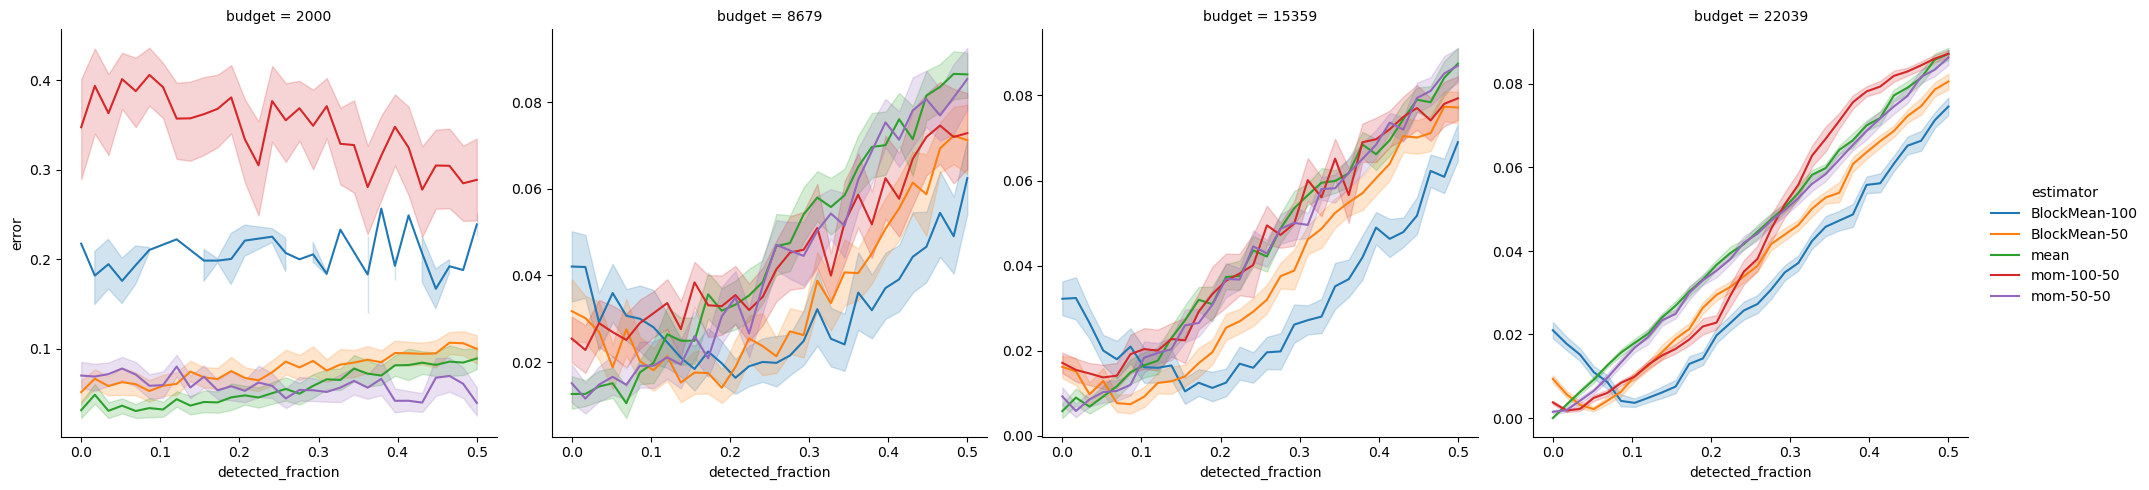

In [ ]:
grid = sns.relplot(
    results.with_columns(
        error=(pl.col("estimated_parity") - pl.lit(tpr_violation)).abs()
    ).filter(pl.col("budget").is_in(AUDIT_BUDGET_VALUES[::3])),
    x="detected_fraction",
    y="error",
    kind="line",
    col="budget",
    hue="estimator",
    facet_kws=dict(sharey=False),
)
# grid.refline(y=tpr_violation)
# grid.set(yscale="log", xscale="log")

As a first order approximation, imagine that we can decompose the error into the statistical bias
(due to finite number of samples) and the adversarial bias (bias introduced by the manipulations of
the platform).

- For low audit budgets, the empirical mean performs best. Interpretation: At low audit budget, the
  statistical bias is predominant; robust estimators have higher statistical bias (because of the
  subdivision into multiple groups).
- For middle to high budgets, there are two regimes: low corruption ($[0, \sim 0.1]$) and high
  corruption ($[0.1, \sim 0.5]$).
  - Low corruption: as before, the statistical bias is predominant. Thus, robust estimators do not
    perform as well as empirical mean.
  - High corruption: the adversarial bias becomes predominant. Since the robust estimators mitigate
    this bias, they perform better than the empirical mean.

## Error as a function of the budget

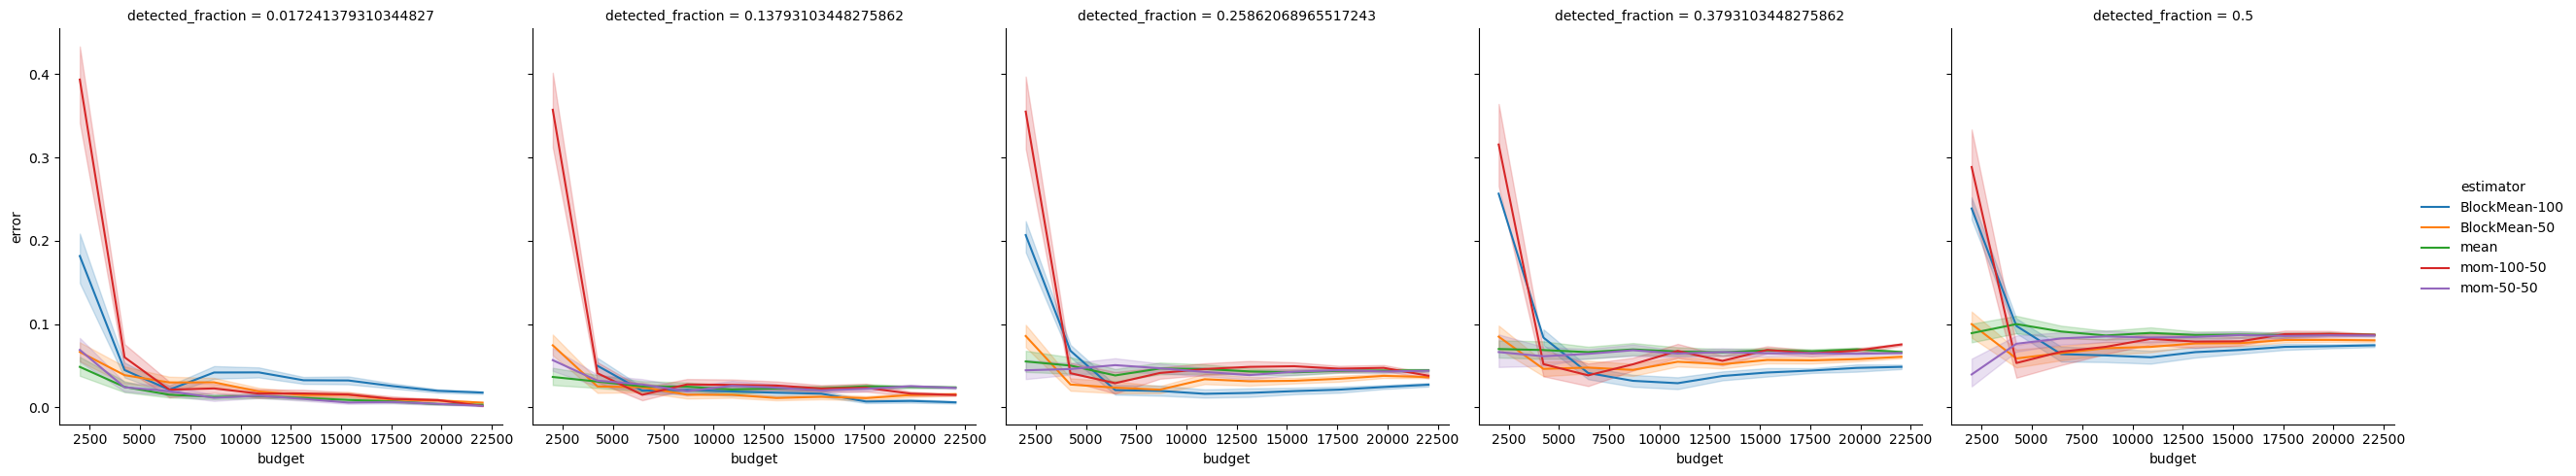

In [ ]:
grid = sns.relplot(
    results.with_columns(
        error=(pl.col("estimated_parity") - pl.lit(tpr_violation)).abs()
    ).filter(
        pl.col("detected_fraction").is_in(pl.lit(CORRUPTED_FRACTION_VALUES[1::7]))
    ),
    x="budget",
    y="error",
    kind="line",
    col="detected_fraction",
    hue="estimator",
)
# grid.set(xscale="log")

Unintuitive result: the robust estimators seem to have an optimal budget. 

## Error as a function of the corrupted fraction

What is the relation between the number of detected audit samples and the number of samples that are actually flipped in the audit set ? 

Well seems to be linear (not very surprising since the audit set is drawn uniformly at random for now)

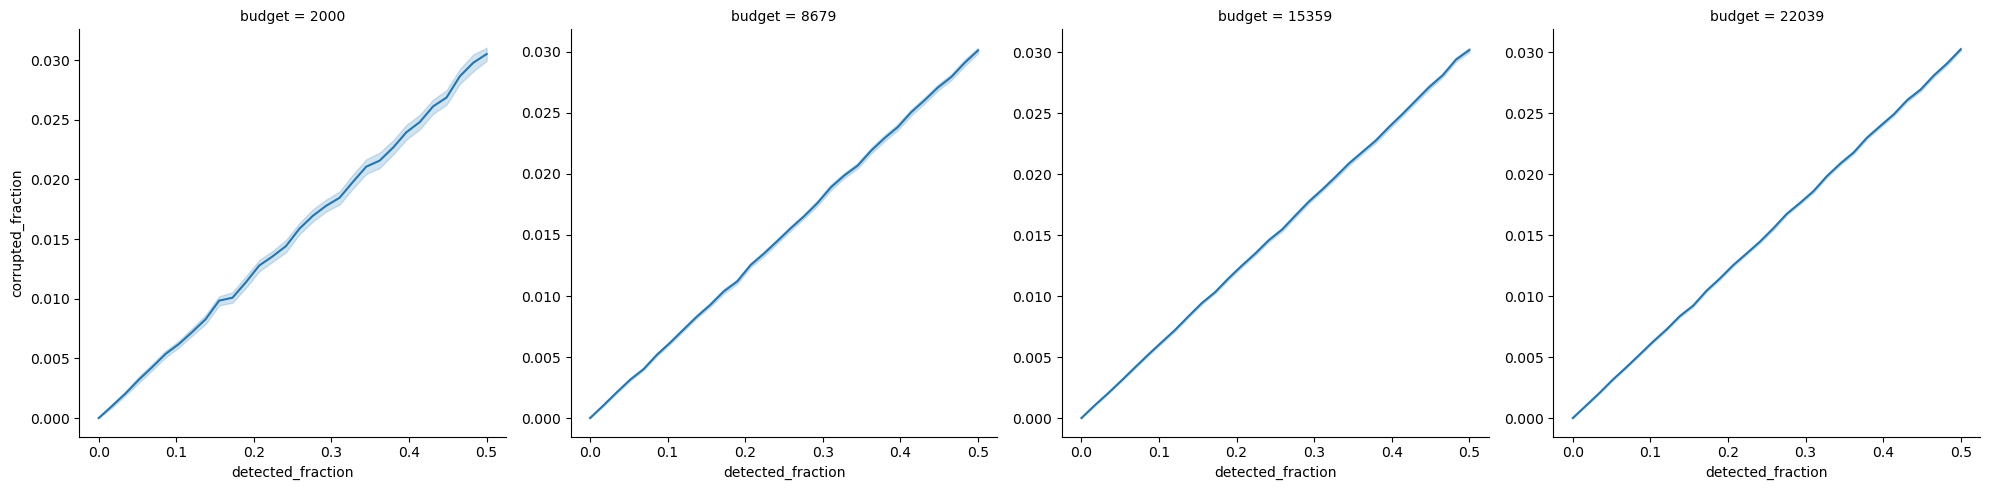

In [ ]:
grid = sns.relplot(
    results.with_columns(
        error=(pl.col("estimated_parity") - pl.lit(tpr_violation)).abs()
    )
    .filter(pl.col("budget").is_in(AUDIT_BUDGET_VALUES[::3]))
    .group_by(pl.col("*").exclude("error", "corrupted_fraction"))
    .mean(),
    x="detected_fraction",
    y="corrupted_fraction",
    kind="line",
    col="budget",
    # hue="estimator",
    facet_kws=dict(sharey=False),
)

In [ ]:
results.with_columns(
    error=(pl.col("estimated_parity") - pl.lit(tpr_violation)).abs()
).filter(pl.col("budget").is_in(AUDIT_BUDGET_VALUES[::3])).sort(
    "estimator", "budget", "corrupted_fraction"
).with_columns(
    test=pl.col("corrupted_fraction").rolling_mean(5, warn_if_unsorted=True)
)

estimated_parity,estimator,detected_fraction,budget,corrupted_fraction,error,test
f64,str,f64,i64,f64,f64,f64
NaN,"""BlockMean-100""",0.0,2000,0.0,NaN,null
NaN,"""BlockMean-100""",0.0,2000,0.0,NaN,null
NaN,"""BlockMean-100""",0.0,2000,0.0,NaN,null
NaN,"""BlockMean-100""",0.0,2000,0.0,NaN,null
NaN,"""BlockMean-100""",0.017241,2000,0.0,NaN,0.0
NaN,"""BlockMean-100""",0.0,2000,0.0,NaN,0.0
NaN,"""BlockMean-100""",0.0,2000,0.0,NaN,0.0
NaN,"""BlockMean-100""",0.0,2000,0.0,NaN,0.0
NaN,"""BlockMean-100""",0.0,2000,0.0,NaN,0.0


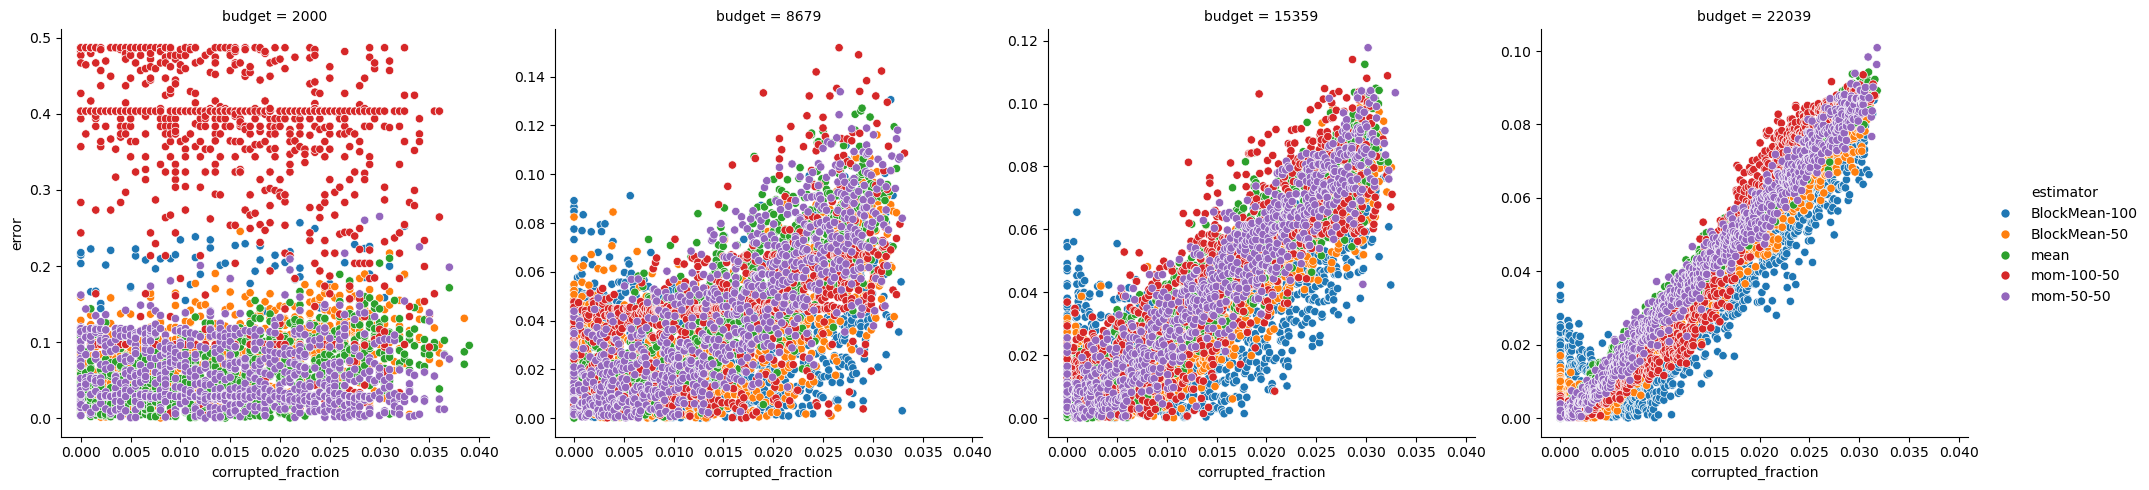

In [ ]:
grid = sns.relplot(
    results.with_columns(
        error=(pl.col("estimated_parity") - pl.lit(tpr_violation)).abs()
    )
    .filter(pl.col("budget").is_in(AUDIT_BUDGET_VALUES[::3]))
    .sort("estimator", "budget", "corrupted_fraction")
    .with_columns(
        test=pl.col("corrupted_fraction").rolling_mean(5, warn_if_unsorted=True)
    ),
    x="corrupted_fraction",
    y="error",
    # kind="line",
    col="budget",
    hue="estimator",
    facet_kws=dict(sharey=False),
)

# Tests with a discrimination sampling attack

(attack suggested by Jade)

## Attack description

We select points for which the decision is uncertain (high entropy of the predicted class
distribution). Then the decision is flipped in favor of the discriminated group on these points to
increase the fairness.

In [ ]:
def ROC_mitigation(y_pred_proba: np.ndarray, is_sensitive: np.ndarray, theta: float):
    """
    Implementation of the Reject Option based Classification method (Kamiran et al., (2012)).
    """

    # Get the labels from the probabilities
    y_pred = y_pred_proba.argmax(axis=1)

    # Select the labels we want to flip. We select the ones which have a low
    # confidence (a.k.a. high entropy of the class distribution)
    max_values = np.maximum(y_pred_proba[:, 0], y_pred_proba[:, 1])
    critical_region = max_values <= theta

    # Always answer yes to the discriminated group
    y_pred[(critical_region & is_sensitive).astype(bool)] = 1
    # Always answer no to the non-discriminated group
    y_pred[(critical_region & (~is_sensitive)).astype(bool)] = 0

    return y_pred

In [ ]:
# Train the final unfair model
model = make_pipeline(
    StandardScaler(),
    LGBMClassifier(
        max_depth=max_depth.item(),
        n_estimators=n_estimators.item(),
        random_state=1234,
        verbose=-1,  # Supress info and warning logs
    ),
)
model.fit(X_train, y_train)


yhat = model.predict(X_test)
white_tpr = np.mean(yhat[(y_test == 1) & (group_test == 1)]).item()
black_tpr = np.mean(yhat[(y_test == 1) & (group_test == 2)]).item()

tpr_violation = white_tpr - black_tpr
print(
    f"Accurate model score {model.score(X_test, y_test):.3f}",
    f"| TPR violation {tpr_violation:.3f}",
)

print(f"{X_test.shape = }")

y_pred_proba = model.predict_proba(X_test)
y_pred = y_pred_proba.argmax(axis=1)
records = []

for alpha in np.linspace(0.5, 0.59, num=30, endpoint=True):
    y_obs = ROC_mitigation(y_pred_proba, group_test == 2, alpha)

    records.append(
        {
            "alpha": alpha,
            "corrupted_fraction": np.sum(y_pred != y_obs) / len(y_pred),
            "estimated_parity": np.mean(y_obs[(y_test == 1) & (group_test == 1)])
            - np.mean(y_obs[(y_test == 1) & (group_test == 2)]),
        }
    )

ROC_attack_results = pl.from_records(records)

Accurate model score 0.820 | TPR violation 0.263
X_test.shape = (22039, 10)


To get an idea of the effect of the parameter `alpha`, we plot its impact on the estimated parity and on the proportion of flipped outputs.

<Axes: xlabel='alpha', ylabel='corrupted_fraction'>

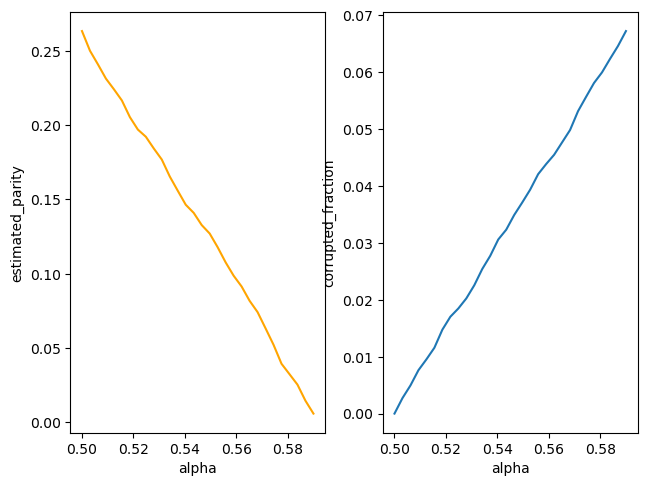

In [ ]:
fig, axes = plt.subplots(1, 2, sharex="all")
fig.tight_layout()
sns.lineplot(
    ROC_attack_results, x="alpha", y="estimated_parity", color="orange", ax=axes[0]
)
sns.lineplot(ROC_attack_results, x="alpha", y="corrupted_fraction", ax=axes[1])

## Experiments

In [ ]:
ROC_ALPHA_VALUES = np.linspace(0.5, 0.59, num=30, endpoint=True)

records = []

y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

for i_rep in range(N_REPETITIONS):
    print(i_rep, end=" ")
    for (estimator_name, estimator), alpha, audit_budget in product(
        ESTIMATORS.items(), ROC_ALPHA_VALUES, AUDIT_BUDGET_VALUES
    ):
        # Use the budget to flip decisions
        y_obs = ROC_mitigation(y_pred_proba, group_test == 2, alpha)

        # Audit set
        audit_set = rng.choice(y_pred_proba.shape[0], size=audit_budget, replace=False)
        y_true = y_test[audit_set]
        y_obs = y_obs[audit_set]
        group = group_test[audit_set]

        # Effectively corrupted samples
        corrupted_fraction = np.mean(y_obs != y_pred[audit_set])

        records.append(
            {
                "estimated_parity": (
                    estimator(y_obs[(y_true == 1) & (group == 1)])
                    - estimator(y_obs[(y_true == 1) & (group == 2)])
                ),
                "estimator": estimator_name,
                "corrupted_fraction": corrupted_fraction,
                "budget": audit_budget,
                "ROC_alpha": alpha,
            }
        )

ROC_results = pl.from_records(records).sort("estimator")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

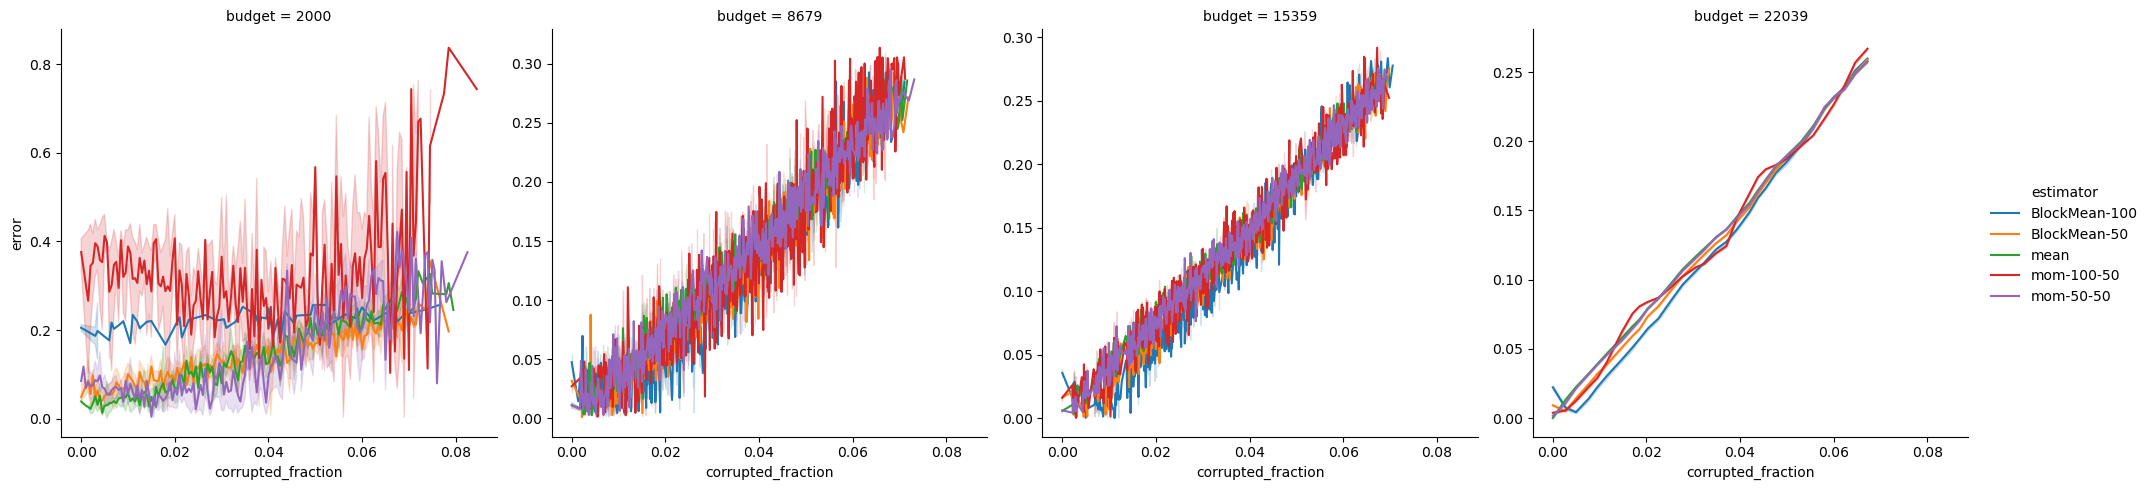

In [ ]:
grid = sns.relplot(
    ROC_results.with_columns(
        error=(pl.col("estimated_parity") - pl.lit(tpr_violation)).abs()
    ).filter(pl.col("budget").is_in(AUDIT_BUDGET_VALUES[::3])),
    x="corrupted_fraction",
    y="error",
    kind="line",
    col="budget",
    hue="estimator",
    facet_kws=dict(sharey=False),
)

Pretty much the same results as before, except that the attack is able to induce a much larger estimation error for a much smaller budget

# TL;DR

In [ ]:
N_CORRUPTED_FRACTION_BINS = 10

summary = (
    pl.concat(
        [
            results.with_columns(attack=pl.lit("sandbox")),
            ROC_results.with_columns(attack=pl.lit("ROC")),
        ],
        how="align",
    )
    .filter(
        (pl.col("budget") == pl.lit(15_359))
        & pl.col("estimator").is_in(["BlockMean-100", "mean"])
    )
    .with_columns(
        corrupted_fraction_bin=pl.col("corrupted_fraction").qcut(
            N_CORRUPTED_FRACTION_BINS
        )
    )
    .group_by("estimator", "attack", "corrupted_fraction_bin")
    .mean()
)

summary

estimator,attack,corrupted_fraction_bin,estimated_parity,detected_fraction,budget,corrupted_fraction,ROC_alpha
str,str,cat,f64,f64,f64,f64,f64
"""BlockMean-100""","""ROC""","""(0.02968943290…",0.147544,null,15359.0,0.035037,0.546894
"""BlockMean-100""","""ROC""","""(0.02057425613…",0.196073,null,15359.0,0.022729,0.531095
"""BlockMean-100""","""sandbox""","""(0.00794322547…",0.26501,0.16954,15359.0,0.010125,null
"""BlockMean-100""","""ROC""","""(0.04069275343…",0.092383,null,15359.0,0.047085,0.563784
"""BlockMean-100""","""ROC""","""(0.02515788788…",0.175858,null,15359.0,0.027311,0.536508
"""mean""","""sandbox""","""(0.02515788788…",0.185835,0.452061,15359.0,0.027434,null
"""mean""","""ROC""","""(0.01679796861…",0.190291,null,15359.0,0.018541,0.524914
"""mean""","""sandbox""","""(0.01204505501…",0.221362,0.238916,15359.0,0.014361,null
"""mean""","""ROC""","""(0.00794322547…",0.221277,null,15359.0,0.01039,0.513787


Text(0.5, 1.0, 'Audit manipulability under different audit strategies')

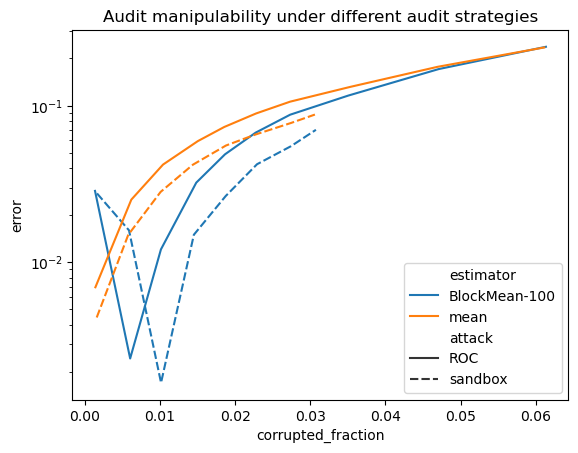

In [ ]:
ax = sns.lineplot(
    summary.with_columns(
        error=(pl.col("estimated_parity") - pl.lit(tpr_violation)).abs()
    ),
    x="corrupted_fraction",
    y="error",
    style="attack",
    hue="estimator",
)
ax.set_yscale("log")
ax.set_title("Audit manipulability under different audit strategies")